<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/JB_PJ_Time_series_1_Monthly_Robberies_Boston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I- Base method

In [ ]:
!pip install pmdarima

In [ ]:
# evaluate a persistence model
import pmdarima as pm
import pandas as pd
import numpy as np

from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import log
from math import exp
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from pandas import Grouper
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns; sns.set()

The problem is to predict the number of monthly armed robberies in Boston, USA. The dataset
provides the number of monthly armed robberies in Boston from January 1966 to October 1975,
or just under 10 years of data. The values are a count and there are 118 observations. The
dataset is credited to McCleary and Hay (1980). Below is a sample of the first few rows of the
dataset.

In [ ]:
# split into a training and validation dataset
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-robberies.csv',
                  header=0, index_col=0, parse_dates=True, squeeze=True)
series

Month
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43
             ... 
1975-06-01    316
1975-07-01    398
1975-08-01    394
1975-09-01    431
1975-10-01    431
Name: Robberies, Length: 118, dtype: int64

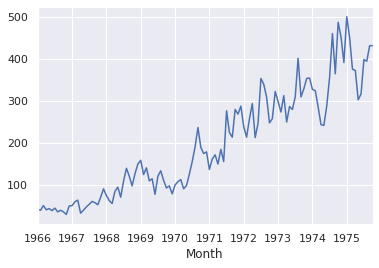

In [ ]:
series.plot()

In [ ]:
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

Dataset 106, Validation 12


# Persistence (Base model)

The first step before getting bogged down in data analysis and modeling is to establish a baseline
of performance. This will provide both a template for evaluating models using the proposed
test harness and a performance measure by which all more elaborate predictive models can be
compared. The baseline prediction for time series forecasting is called the naive forecast, or
persistence. This is where the observation from the previous time step is used as the prediction
for the observation at the next time step. We can plug this directly into the test harness defined
in the previous section. The complete code listing is provided below.

In [ ]:
# prepare data
X = dataset
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  #print(i)
  yhat = history[-1] # Training set, predict from previous time step
  predictions.append(yhat)
  # observation
  obs = test[i] # current time step
  history.append(obs) # Add thsi current time step to history for next prediction
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))

>Predicted=98.000, Expected=125.000
>Predicted=125.000, Expected=155.000
>Predicted=155.000, Expected=190.000
>Predicted=190.000, Expected=236.000
>Predicted=236.000, Expected=189.000
>Predicted=189.000, Expected=174.000
>Predicted=174.000, Expected=178.000
>Predicted=178.000, Expected=136.000
>Predicted=136.000, Expected=161.000
>Predicted=161.000, Expected=171.000
>Predicted=171.000, Expected=149.000
>Predicted=149.000, Expected=184.000
>Predicted=184.000, Expected=155.000
>Predicted=155.000, Expected=276.000
>Predicted=276.000, Expected=224.000
>Predicted=224.000, Expected=213.000
>Predicted=213.000, Expected=279.000
>Predicted=279.000, Expected=268.000
>Predicted=268.000, Expected=287.000
>Predicted=287.000, Expected=238.000
>Predicted=238.000, Expected=213.000
>Predicted=213.000, Expected=257.000
>Predicted=257.000, Expected=293.000
>Predicted=293.000, Expected=212.000
>Predicted=212.000, Expected=246.000
>Predicted=246.000, Expected=353.000
>Predicted=353.000, Expected=339.000
>P

In [ ]:
print('RMSE: %.3f' % rmse)

RMSE: 51.844


Running the test harness prints the prediction and observation for each iteration of the test
dataset. The example ends by printing the RMSE for the model. In this case, we can see that
the persistence model achieved an RMSE of 51.844. This means that on average, the model was
wrong by about 51 robberies for each prediction made

# Data Analysis

In [ ]:
series=dataset

In [ ]:
series.describe()

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: Robberies, dtype: float64

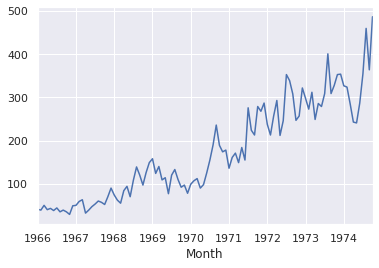

In [ ]:
series.plot()

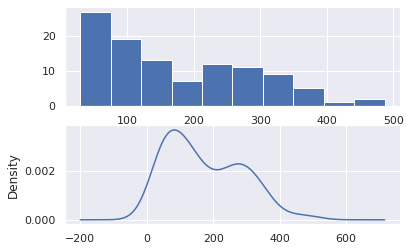

In [ ]:
plt.figure(1)
plt.subplot(211)
series.hist()
plt.subplot(212)
series.plot(kind='kde')
plt.show()

Run the example and review the plots. Some observations from the plots include:

 The distribution is not Gaussian.

 The distribution is left shifted and may be exponential or a double Gaussian.

We can group the monthly data by year and get an idea of the spread of observations for each
year and how this may be changing. We do expect to see some trend (increasing mean or
median), but it may be interesting to see how the rest of the distribution may be changing. The
example below groups the observations by year and creates one box and whisker plot for each
year of observations. The last year (1974) only contains 10 months and may not be a useful
comparison with the other 12 months of observations in the other years. Therefore only data
between 1966 and 1973 was plotted

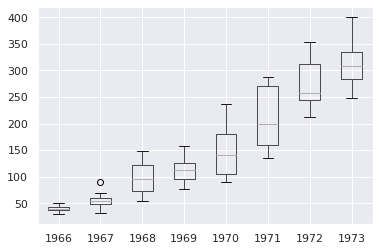

In [ ]:
groups = series['1966':'1973'].groupby(Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
  years[name.year] = group.values
years.boxplot()

In [ ]:
series_df=pd.DataFrame(series).reset_index()
series_df

,Month,Robberies
0,1966-01-01,41
1,1966-02-01,39
2,1966-03-01,50
3,1966-04-01,40
4,1966-05-01,43
...,...,...
101,1974-06-01,287
102,1974-07-01,355
103,1974-08-01,460
104,1974-09-01,364


In [ ]:
series_df['year']=series_df['Month'].dt.year

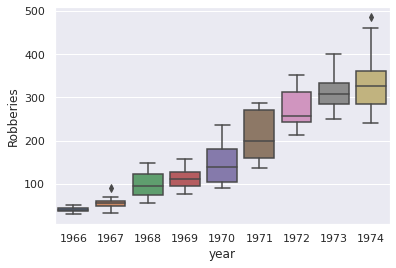

In [ ]:
sns.boxplot(x="year", y="Robberies", data=series_df)

 The median values for each year (red line) show a trend that may not be linear.

 The spread, or middle 50% of the data (blue boxes), differ, but perhaps not consistently
over time.

 The earlier years, perhaps first 2, are quite different from the rest of the dataset

The observations suggest that the year-to-year fluctuations may not be systematic and hard
to model. They also suggest that there may be some benefit in clipping the first two years of
data from modeling if it is indeed quite different. This yearly view of the data is an interesting
avenue and could be pursued further by looking at summary statistics from year-to-year and
changes in summary stats from year-to-year. Next, we can start looking at predictive models of
the series.

# ARIMA Models

( Autoregressive Integrated Moving Average)

## Manually Configured ARIMA

In [ ]:
# create a differenced time series
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return Series(diff)

In [ ]:
# difference data
series=dataset
X = series.values
stationary = difference(X)
stationary.index = series.index[1:]
stationary

Month
1966-02-01     -2
1966-03-01     11
1966-04-01    -10
1966-05-01      3
1966-06-01     -5
             ... 
1974-06-01     46
1974-07-01     68
1974-08-01    105
1974-09-01    -96
1974-10-01    123
Length: 105, dtype: int64

In [ ]:
series

Month
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43
             ... 
1974-06-01    287
1974-07-01    355
1974-08-01    460
1974-09-01    364
1974-10-01    487
Name: Robberies, Length: 106, dtype: int64

In [ ]:
# check if stationary
result = adfuller(stationary)
result

(-3.9809463038611157,
 0.0015136348242122454,
 11,
 93,
 {'1%': -3.502704609582561,
  '10%': -2.583636712914788,
  '5%': -2.8931578098779522},
 922.2383070792222)

In [ ]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


Running the example outputs the result of a statistical  significance test of whether the 1-lag
differenced series is stationary. Specifically, the augmented Dickey-Fuller test. The results show
that the test statistic value -3.980946 is smaller than the critical value at 5% of -2.893. This
suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a
low probability that the result is a statistical fluke). Rejecting the null hypothesis means that
the process has no unit root, and in turn that the 1-lag differenced time series is stationary or
does not have time-dependent structure. (not trend or seasons)

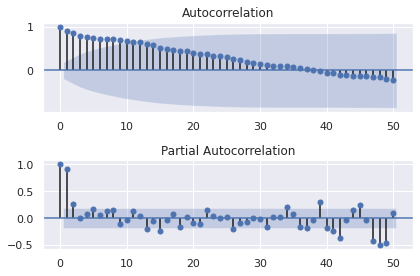

In [ ]:
plt.figure()
plt.subplot(211)
plot_acf(series, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, lags=50, ax=plt.gca())
plt.tight_layout()
plt.show()

Run the example and review the plots for insights into how to set the p and q variables for
the ARIMA model. Below are some observations from the plots.

 The ACF shows a significant lag for 10-11 months.

 The PACF shows a significant lag for perhaps 2 months.

 Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of
AR and MA.

A good starting point for the p and q values are 11 and 2.

This quick analysis suggests an ARIMA(11,1,2) on the raw data may be a good starting
point. Experimentation shows that this configuration of ARIMA does not converge and results
in errors by the underlying library, as do similarly large AR values. Some experimentation shows
that the model does not appear to be stable, with non-zero AR and MA orders defined at the
same time. The model can be simplified to ARIMA(0,1,2). The example below demonstrates
the performance of this ARIMA model on the test harness.

In [ ]:
# evaluate manually configured ARIMA model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
# prepare data
X = dataset
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(0,1,2))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=102.710, Expected=125.000
>Predicted=118.868, Expected=155.000
>Predicted=141.099, Expected=190.000
>Predicted=176.593, Expected=236.000
>Predicted=233.418, Expected=189.000
>Predicted=186.905, Expected=174.000
>Predicted=184.846, Expected=178.000
>Predicted=183.763, Expected=136.000
>Predicted=146.180, Expected=161.000
>Predicted=171.279, Expected=171.000
>Predicted=170.196, Expected=149.000
>Predicted=154.425, Expected=184.000
>Predicted=185.707, Expected=155.000
>Predicted=157.284, Expected=276.000
>Predicted=245.280, Expected=224.000
>Predicted=222.242, Expected=213.000
>Predicted=219.698, Expected=279.000
>Predicted=261.506, Expected=268.000
>Predicted=264.287, Expected=287.000
>Predicted=282.759, Expected=238.000
>Predicted=255.843, Expected=213.000
>Predicted=235.189, Expected=257.000
>Predicted=257.622, Expected=293.000
>Predicted=280.345, Expected=212.000
>Predicted=235.564, Expected=246.000
>Predicted=255.342, Expected=353.000
>Predicted=318.613, Expected=339.000
>

## Grid Search ARIMA Hyperparameters

Many ARIMA configurations are unstable on this dataset, but there may be other hyperparameters that result in a well-performing model. In this section, we will search values of p, d, and q
for combinations that do not result in error, and find the combination that results in the best
performance. We will use a grid search to explore all combinations in a subset of integer values.
Specifically, we will search all combinations of the following parameters:

 p: 0 to 12.

 d: 0 to 3.

 q: 0 to 12.

This is (13 × 4 × 13), or 676, runs of the test harness and will take some time to execute.
The complete worked example with the grid search version of the test harness is listed below.

In [ ]:
# grid search ARIMA parameters for time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
            continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# load dataset  
series = dataset
# evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=154.962
ARIMA(0, 0, 1) RMSE=99.360
ARIMA(0, 0, 2) RMSE=89.842
ARIMA(0, 0, 3) RMSE=72.274
ARIMA(0, 0, 4) RMSE=73.010
ARIMA(0, 0, 5) RMSE=65.252
ARIMA(0, 1, 0) RMSE=51.827
ARIMA(0, 1, 1) RMSE=50.417


Best: ARIMA(0,1,2) RMSE =49.821

## Review Residual Errors

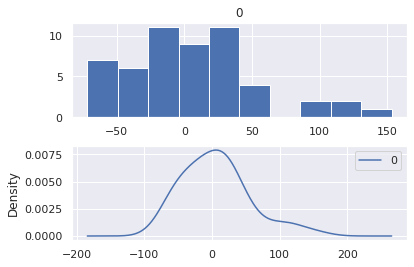

In [ ]:
# plot residual errors for ARIMA model
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
# prepare data
series=dataset
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(0,1,2))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

Running the example creates the two plots. The graphs suggest a Gaussian-like distribution
with a longer right tail. This is perhaps a sign that the predictions are biased, and in this case
that perhaps a power-based transform of the raw data before modeling might be useful.

It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal
structure in the data. The example below re-calculates the residual errors and creates ACF and
PACF plots to check for any significant autocorrelation.

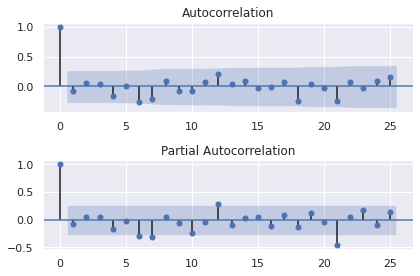

In [ ]:
# ACF and PACF plots of forecast residual errors
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

# prepare data
series=dataset
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(0,1,2))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, lags=25, ax=pyplot.gca())
pyplot.tight_layout()
pyplot.show()

The results suggest that what little autocorrelation is present in the time series has been
captured by the model.

## Box-Cox Transformed Dataset

The Box-Cox transform is a method that is able to evaluate a suite of power transforms,
including, but not limited to, log, square root, and reciprocal transforms of the data. The
example below performs a log transform of the data and generates some plots to review the
effect on the time series.

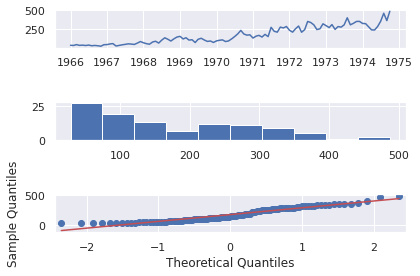

In [ ]:
# NOT TRANSFORM COMPARE
# line plot
pyplot.subplot(311)
pyplot.plot(series)
# histogram
pyplot.subplot(312)
pyplot.hist(series)
# q-q plot
pyplot.subplot(313)
qqplot(series, line='r', ax=pyplot.gca())
pyplot.tight_layout()
pyplot.show()

Lambda value (λ)	Transformed data (Y’)

-3	Y-3 = 1/Y3

-2	Y-2 = 1/Y2

-1	Y-1 = 1/Y1

-0.5	Y-0.5 = 1/(√(Y))

0	log(Y)**

0.5	Y0.5 = √(Y)

1	Y1 = Y

2	Y2

3	Y3


Lambda: 0.260060


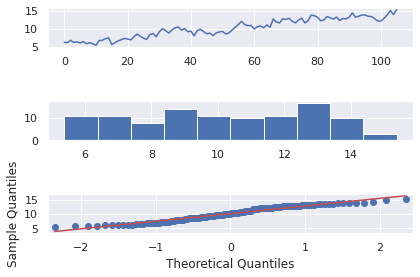

In [ ]:
# plots of box-cox transformed dataset
from pandas import read_csv
from scipy.stats import boxcox
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
series=dataset
X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.tight_layout()
pyplot.show()

Running the example creates three graphs: a line chart of the transformed time series, a
histogram showing the distribution of transformed values, and a Q-Q plot showing how the
distribution of values compared to an idealized Gaussian distribution. Some observations from
these plots are follows:

 The large fluctuations have been removed from the line plot of the time series.

 The histogram shows a flatter or more uniform (well behaved) distribution of values.

 The Q-Q plot is reasonable, but still not a perfect fit for a Gaussian distribution.

Undoubtedly, the Box-Cox transform has done something to the time series and may be
useful. Before proceeding to test the ARIMA model with the transformed data, we must have
a way to reverse the transform in order to convert predictions made with a model trained on
the transformed data back into the original scale. The boxcox() function used in the example
finds an ideal lambda value by optimizing a cost function. The lambda is used in the following

In [ ]:
# invert Box-Cox transform
from math import log
from math import exp
def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)

We can re-evaluate the ARIMA(0,1,2) model with the Box-Cox transform. This involves
first transforming the history prior to fitting the ARIMA model, then inverting the transform
on the prediction before storing it for later comparison with the expected values. The boxcox()
function can fail. In practice, I have seen this and it appears to be signaled by a returned
lambda value of less than -5. By convention, lambda values are evaluated between -5 and 5.

A check is added for a lambda value less than -5, and if this the case, a lambda value of 1
is assumed and the raw history is used to fit the model. A lambda value of 1 is the same as
no-transform and therefore the inverse transform has no effect. The complete example is listed
below.

In [ ]:
# prepare data
series=dataset
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
  # transform
  transformed, lam = boxcox(history)
  if lam < -5:
    transformed, lam = history, 1
  # predict
  model = ARIMA(transformed, order=(0,1,2))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=104.062, Expected=125.000
>Predicted=119.209, Expected=155.000
>Predicted=138.903, Expected=190.000
>Predicted=166.146, Expected=236.000
>Predicted=205.831, Expected=189.000
>Predicted=183.612, Expected=174.000
>Predicted=184.411, Expected=178.000
>Predicted=186.637, Expected=136.000
>Predicted=154.274, Expected=161.000
>Predicted=175.673, Expected=171.000
>Predicted=174.165, Expected=149.000
>Predicted=159.916, Expected=184.000
>Predicted=187.302, Expected=155.000
>Predicted=161.653, Expected=276.000
>Predicted=244.354, Expected=224.000


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


>Predicted=212.415, Expected=213.000
>Predicted=221.180, Expected=279.000
>Predicted=262.629, Expected=268.000
>Predicted=260.125, Expected=287.000
>Predicted=283.321, Expected=238.000
>Predicted=255.089, Expected=213.000
>Predicted=241.694, Expected=257.000
>Predicted=267.304, Expected=293.000
>Predicted=286.368, Expected=212.000
>Predicted=237.871, Expected=246.000
>Predicted=265.184, Expected=353.000
>Predicted=323.318, Expected=339.000
>Predicted=318.584, Expected=308.000
>Predicted=315.816, Expected=247.000
>Predicted=279.561, Expected=257.000
>Predicted=289.125, Expected=322.000
>Predicted=323.738, Expected=298.000
>Predicted=305.205, Expected=273.000
>Predicted=297.093, Expected=312.000
>Predicted=322.521, Expected=249.000
>Predicted=275.872, Expected=286.000
>Predicted=307.548, Expected=279.000
>Predicted=291.949, Expected=309.000
>Predicted=315.578, Expected=401.000
>Predicted=369.477, Expected=309.000
>Predicted=316.868, Expected=328.000
>Predicted=345.388, Expected=353.000
>

# Model Validation

 Finalize Model: Train and save the final model.

 Make Prediction: Load the finalized model and 
make a prediction.

 Validate Model: Load and validate the final model.

Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case, on a
transformed version of the entire dataset. Once fit, the model can be saved to file for later use.
Because a Box-Cox transform is also performed on the data, we need to know the chosen lambda
so that any predictions from the model can be converted back to the original, untransformed
scale. The example below fits an ARIMA(0,1,2) model on the Box-Cox transform dataset and
saves the whole fit object and the lambda value to file.

There is a bug in the current version of the Statsmodels library that results in an error when
you try to load a saved ARIMA model from file. Learn more about this bug and the workaround
in Appendix B. The example below saves the fit model to file in the correct state so that it can
be loaded successfully later.

In [ ]:
# finalize model and save to file with workaround
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
  return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
  
ARIMA.__getnewargs__ = __getnewargs__

# prepare data
series=dataset
X = series.values
X = X.astype('float32')
# transform data
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(0,1,2))
model_fit = model.fit(disp=0)
# save model
model_fit.save('model.pkl')
numpy.save('model_lambda.npy', [lam])

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [ ]:
model_fit

In [ ]:
transformed

array([ 7.0784383,  6.917589 ,  7.7424335,  6.9987006,  7.234011 ,
        6.835044 ,  7.3099484,  6.5781407,  6.917589 ,  6.5781407,
        6.015231 ,  7.6729136,  7.7424335,  8.329054 ,  8.5701885,
        6.305715 ,  6.917589 ,  7.53091  ,  7.9454536,  8.39036  ,
        8.204278 ,  7.8786736,  8.968132 ,  9.972714 ,  9.183429 ,
        8.510909 ,  8.076474 ,  9.688919 , 10.1547985,  8.968132 ,
       10.753217 , 11.910597 , 11.225236 , 10.287915 , 11.44921  ,
       12.245811 , 12.534598 , 11.375378 , 11.944845 , 10.793882 ,
       10.993472 ,  9.339736 , 11.225236 , 11.701487 , 10.834293 ,
       10.064432 , 10.287915 ,  9.390913 , 10.375105 , 10.712294 ,
       10.914369 ,  9.972714 , 10.331662 , 11.4123955, 12.439615 ,
       13.47849  , 14.660947 , 13.450709 , 13.021394 , 13.138275 ,
       11.806829 , 12.628358 , 12.932523 , 12.245811 , 13.310278 ,
       12.439615 , 15.5667925, 14.368865 , 14.091577 , 15.631013 ,
       15.393171 , 15.7999935, 14.708633 , 14.091577 , 15.1485

In [ ]:
lam

0.31671462418818697

 model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes
the coefficients and all other internal data returned when fitting the model

 model lambda.npy This is the lambda value stored as a one-row, one-column NumPy
array.


Make Prediction

In [ ]:
# load the finalized model and make a prediction
from statsmodels.tsa.arima_model import ARIMAResults
from math import exp
from math import log
import numpy
# invert box-cox transform
def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)

model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')

yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print('Predicted: %.3f' % yhat)

Predicted: 424.526


## BEST-Validate Model (with split test)

Dataset 106, Validation 12
>Predicted=452.039, Expected=452.000


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


RMSE: 53.079


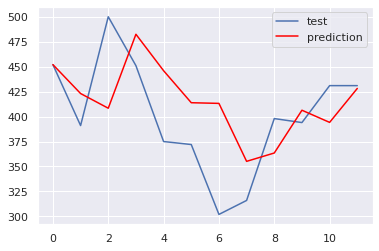

In [ ]:
# evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import exp
from math import log
import numpy

# invert box-cox transform
def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)

# monkey patch around bug in ARIMA class
#def __getnewargs__(self):
#  return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
#ARIMA.__getnewargs__ = __getnewargs__

#Load and split data
#series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-robberies.csv',
              #    header=0, index_col=0, parse_dates=True, squeeze=True)
#split_point = int(len(series) * 0.7)
#split_point = len(series) - 12

#dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

X = dataset.values.astype('float32')
history = [x for x in X]

y = validation.values.astype('float32')

# transform data
transformed, lam = boxcox(X)

# fit model
model = ARIMA(transformed, order=(0,1,2))
model_fit = model.fit(disp=0)
# save model
#model_fit.save('model.pkl')
#numpy.save('model_lambda.npy', [lam])

# load model
#model_fit = ARIMAResults.load('model.pkl')
#lam = numpy.load('model_lambda.npy')
# make first prediction

predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
  # transform
  transformed, lam = boxcox(history)
  if lam < -5:
    transformed, lam = history, 1
  # predict
  model = ARIMA(transformed, order=(0,1,2))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y,label='test')
pyplot.plot(predictions, color='red',label='prediction')
pyplot.legend()
pyplot.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [ ]:
forecast_accuracy(np.array(predictions), y)

{'corr': 0.4057424315533984,
 'mae': 42.074855955318945,
 'mape': 0.11159158319048072,
 'me': 14.449734423661122,
 'minmax': 0.09775918990620303,
 'mpe': 0.05127998607209464,
 'rmse': 53.078764329833795}

Running the example prints each prediction and expected value for the time steps in the
validation dataset. The final RMSE for the validation period is predicted at 53 robberies. This
is not too different to the expected error of 49, but I would expect that it is also not too different
from a simple persistence model.

A plot of the predictions compared to the validation dataset is also provided. The forecast
does have the characteristic of a persistence forecast. This does suggest that although this time
series does have an obvious trend, it is still a reasonably difficult problem.

# II- Another method

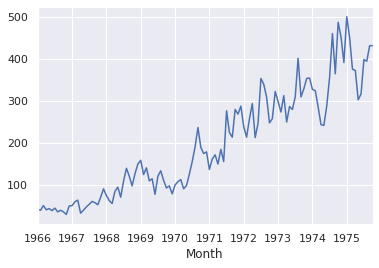

In [ ]:
# split into a training and validation dataset
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-robberies.csv',
                  header=0, index_col=0, parse_dates=True, squeeze=True)
series

series.plot()

## Find p value

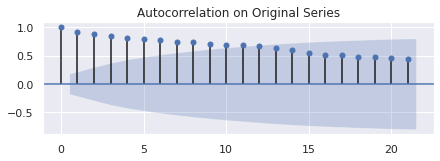

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(311)
fig = plot_acf(series, ax=ax1,
               title="Autocorrelation on Original Series") 

The ACF shows a significant lag for 10-11 months

Choose lag: p=11 or 12

## Find d value

In [ ]:
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.001102
p-value: 0.994278
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


Not reject hypothesis, it is non stationary, must have level of differencing for remove trend/season

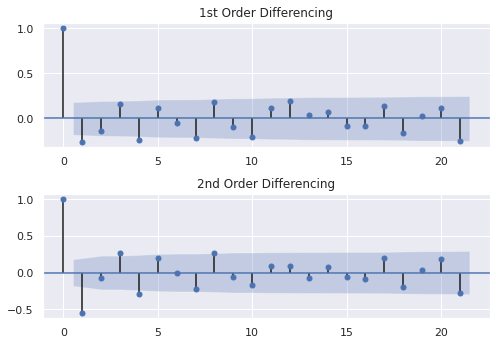

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax2 = fig.add_subplot(311)
fig = plot_acf(series.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(312)
fig = plot_acf(series.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")
plt.tight_layout()
plt.show()

The timeseries is stationary at d = 1 where only the first lag is above the significance level

In [ ]:
# create a differenced time series
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return Series(diff)

In [ ]:
X = series.values
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.428564
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


This
suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a
low probability that the result is a statistical fluke). Rejecting the null hypothesis means that
the process has no unit root, and in turn that the 1-lag differenced time series is stationary or
does not have time-dependent structure. This suggests that at least one level of differencing is required. The d parameter in our
ARIMA model should at least be a value of 1.

## Find q value

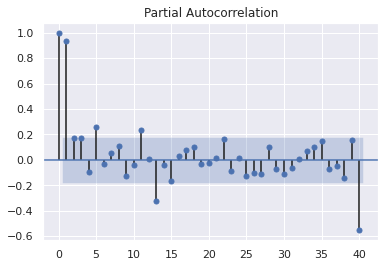

In [ ]:
plot_pacf(series, lags=40, ax=pyplot.gca())
pyplot.show()

The PACF shows a significant lag for perhaps 2 months. q=2

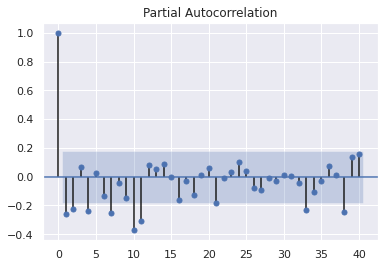

In [ ]:
plot_pacf(series.diff().dropna(), lags=40) #knowing d=1 we apply diff() once
pyplot.show()

p,d,q = (11,1,2)

But Grid search show best is 0,1,2

# Grid search

In [ ]:
# grid search ARIMA parameters for time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
            continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# load dataset  
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-robberies.csv',
                  header=0, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0,3)
d_values = range(0,3)
q_values = range(0,4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=175.285
ARIMA(0, 0, 1) RMSE=107.221
ARIMA(0, 0, 2) RMSE=103.129
ARIMA(0, 0, 3) RMSE=76.054
ARIMA(0, 1, 0) RMSE=54.343
ARIMA(0, 1, 1) RMSE=52.362
ARIMA(0, 1, 2) RMSE=51.007
ARIMA(0, 1, 3) RMSE=53.009
ARIMA(0, 2, 0) RMSE=87.242
ARIMA(0, 2, 1) RMSE=55.084
ARIMA(0, 2, 2) RMSE=53.377
ARIMA(0, 2, 3) RMSE=52.301
ARIMA(1, 0, 0) RMSE=55.085
ARIMA(1, 1, 0) RMSE=52.916
ARIMA(1, 1, 1) RMSE=50.031
ARIMA(1, 2, 0) RMSE=73.795
ARIMA(2, 0, 0) RMSE=53.853
ARIMA(2, 1, 0) RMSE=52.555
ARIMA(2, 1, 1) RMSE=52.512
ARIMA(2, 2, 0) RMSE=62.568
ARIMA(2, 2, 1) RMSE=53.480
Best ARIMA(1, 1, 1) RMSE=50.031


# Auto Arima

In [ ]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=784.088, BIC=793.666, Time=0.114 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=794.601, BIC=799.390, Time=0.010 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=793.253, BIC=800.436, Time=0.041 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=788.011, BIC=795.194, Time=0.055 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=793.116, BIC=795.510, Time=0.009 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=785.572, BIC=797.544, Time=0.158 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=785.218, BIC=797.191, Time=0.166 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=783.246, BIC=792.824, Time=0.077 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=785.229, BIC=797.201, Time=0.120 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=786.309, BIC=800.676, Time=0.285 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0

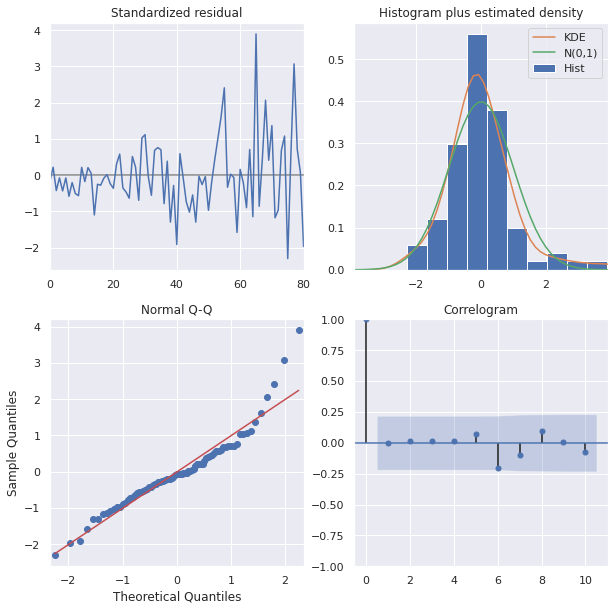

In [ ]:
model.plot_diagnostics(figsize=(10,10))
plt.show()

In [ ]:
model.fit_predict(test)

array([438.22269784, 443.16672475, 447.79644734, 452.42616993,
       457.05589252, 461.68561512, 466.31533771, 470.9450603 ,
       475.57478289, 480.20450549])

# Sarima

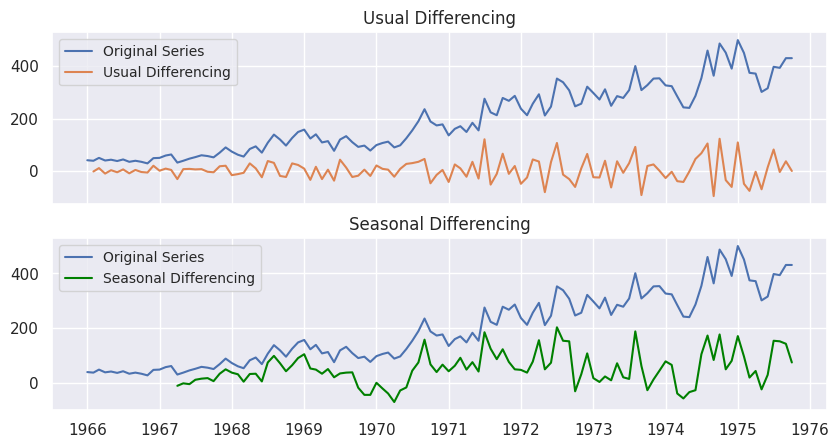

In [ ]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(series[:], label='Original Series')
axes[0].plot(series[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(series[:], label='Original Series')
axes[1].plot(series[:].diff(15), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
#plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [ ]:
model = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=1076.802, BIC=1090.072, Time=1.691 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=1130.059, BIC=1135.367, Time=0.023 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=1099.483, BIC=1110.098, Time=0.674 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=1076.608, BIC=1087.224, Time=0.535 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=1128.074, BIC=1130.728, Time=0.022 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=1101.330, BIC=1109.292, Time=0.188 seconds
Fit ARIMA(0,1,1)x(1,1,1,12) [intercept=True]; AIC=1077.916, BIC=1091.186, Time=0.806 seconds
Fit ARIMA(0,1,1)x(0,1,2,12) [intercept=True]; AIC=1077.409, BIC=1090.679, Time=1.476 seconds
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=True]; AIC=1090.556, BIC=1101.172, Time=0.546 seconds
Fit ARIMA(0,1,1)x(1,1,2,12) [intercept=True]; AIC=1078.424, BIC=1094.348, Time=2.643 seconds
Fit ARIMA(0,1,0)x(0,1,1,12

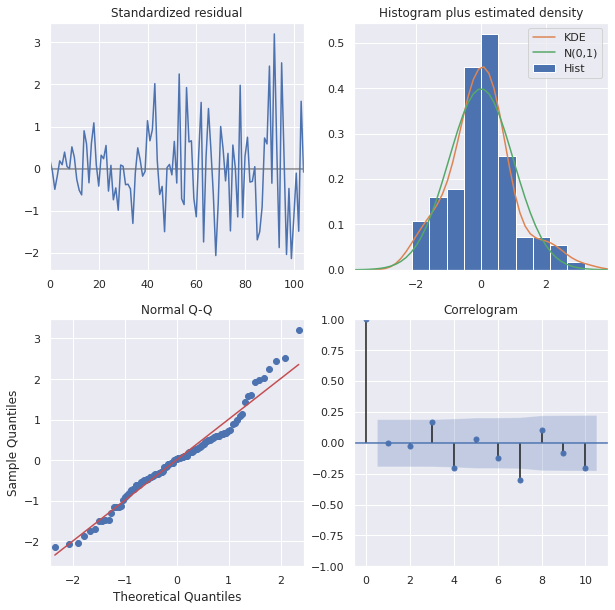

In [ ]:
model.plot_diagnostics(figsize=(10,10))
plt.show()

# Predict Should be used with JB as Base method

This method did not add newest value for prediction

Observations: 118
Training Observations: 82
Testing Observations: 36


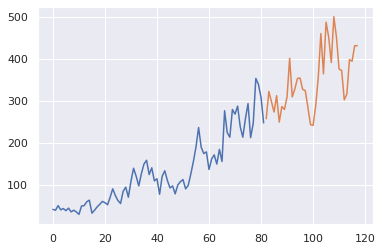

In [ ]:
X = series.values
train_size = int(len(X) * 0.7)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
pyplot.plot(train)
pyplot.plot([None for i in train] + [x for x in test])
pyplot.show()

In [ ]:
len(series)

118

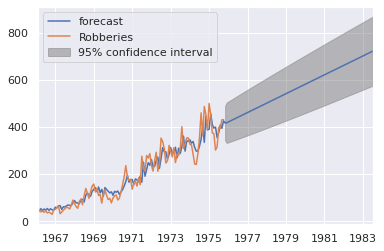

In [ ]:
model = ARIMA(series, order=(0,1,2))
results = model.fit()
results.plot_predict(1, 210)
plt.show()

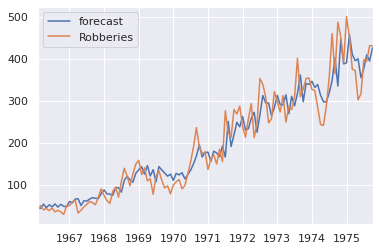

In [ ]:
results.plot_predict(dynamic=False)
plt.show()

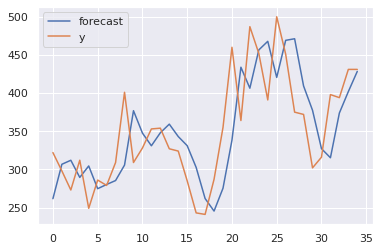

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   35
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -189.434
Method:                       css-mle   S.D. of innovations             54.150
Date:                Thu, 02 Jul 2020   AIC                            386.869
Time:                        13:38:04   BIC                            393.090
Sample:                             1   HQIC                           389.016
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6262      7.259      0.637      0.524      -9.601      18.853
ma.L1.D.y     -0.3312      0.160     -2.075      0.038      -0.644      -0.018
ma.L2.D.y      0.1200      0.329      0.364      0.7

In [ ]:
model = ARIMA(test, order=(0,1,2))
results = model.fit()
results.plot_predict(dynamic=False)
plt.show()
print(results.summary())

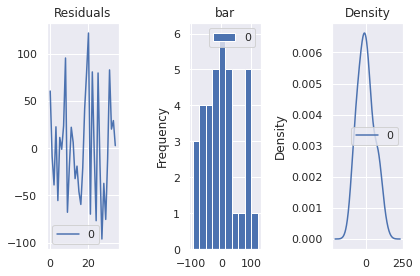

In [ ]:
# Plot residual errors
#plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,3)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='hist',title='bar',ax=ax[1])
residuals.plot(kind='kde', title='Density', ax=ax[2])
plt.tight_layout()
plt.show()

#  Out-of-Time Cross validation

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

Observations: 118
Training Observations: 82
Testing Observations: 36


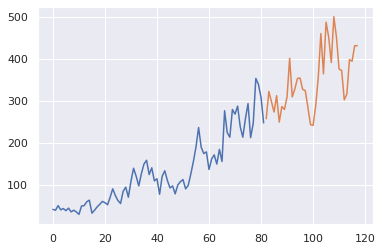

In [ ]:
X = series.values
train_size = int(len(X) * 0.7)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
pyplot.plot(train)
pyplot.plot([None for i in train] + [x for x in test])
pyplot.show()

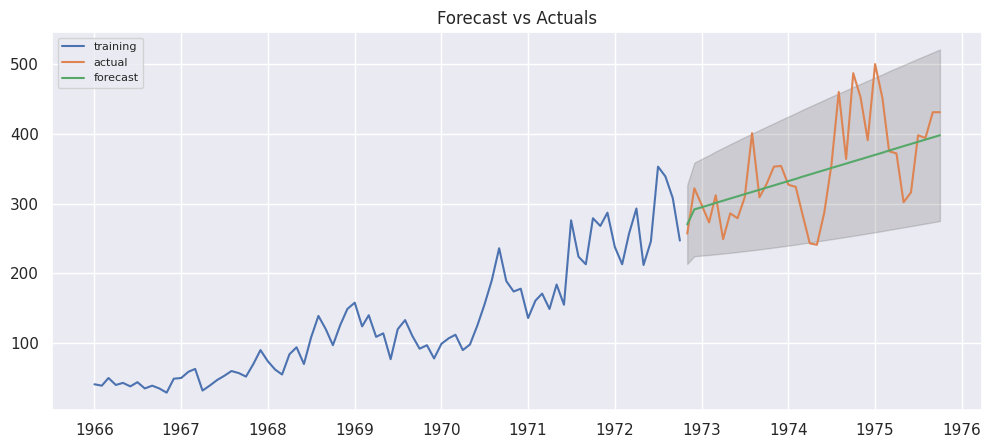

                             ARIMA Model Results                              
Dep. Variable:            D.Robberies   No. Observations:                   81
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -387.623
Method:                       css-mle   S.D. of innovations             28.877
Date:                Thu, 02 Jul 2020   AIC                            783.247
Time:                        13:36:07   BIC                            792.825
Sample:                    02-01-1966   HQIC                           787.089
                         - 10-01-1972                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.1277      1.047      2.988      0.003       1.076       5.179
ma.L1.D.Robberies    -0.3649      0.110     -3.318      0.001      -0.580      -0.149
ma.L2.D.Robberies    -0.

{'corr': 0.6066607746849846,
 'mae': 41.20919950579926,
 'mape': 0.1197348086824616,
 'me': -4.903980197154654,
 'minmax': 0.10640752984767865,
 'mpe': 0.01352877362454356,
 'rmse': 56.45300328905547}

In [ ]:
# Build Model
X = DataFrame(series)
train_size = int(len(X) * 0.7)
train, test = X[0:train_size], X[train_size:len(X)]
model = ARIMA(train, order=(0,1,2))  
fitted = model.fit()#disp=-1  
# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
print(fitted.summary())
forecast_accuracy(fc, test.values.reshape(len(test)))

In [ ]:
forecast_accuracy(fc, test.values.reshape(len(test)))

{'corr': 0.6066607746849846,
 'mae': 41.20919950579926,
 'mape': 0.1197348086824616,
 'me': -4.903980197154654,
 'minmax': 0.10640752984767865,
 'mpe': 0.01352877362454356,
 'rmse': 56.45300328905547}

In [ ]:
model = ARIMA(train, order=(0,1,2))  
fitted = model.fit()#disp=-1  
# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf
print(fitted.summary())
forecast_accuracy(fc, test.values.reshape(len(test)))


                             ARIMA Model Results                              
Dep. Variable:            D.Robberies   No. Observations:                   81
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -387.623
Method:                       css-mle   S.D. of innovations             28.877
Date:                Thu, 02 Jul 2020   AIC                            783.247
Time:                        13:36:08   BIC                            792.825
Sample:                    02-01-1966   HQIC                           787.089
                         - 10-01-1972                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.1277      1.047      2.988      0.003       1.076       5.179
ma.L1.D.Robberies    -0.3649      0.110     -3.318      0.001      -0.580      -0.149
ma.L2.D.Robberies    -0.

{'corr': 0.6066607746849846,
 'mae': 41.20919950579926,
 'mape': 0.1197348086824616,
 'me': -4.903980197154654,
 'minmax': 0.10640752984767865,
 'mpe': 0.01352877362454356,
 'rmse': 56.45300328905547}

In [ ]:
model = ARIMA(train, order=(3,0,2))  
fitted = model.fit()#disp=-1  
# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf
print(fitted.summary())
forecast_accuracy(fc, test.values.reshape(len(test)))

                              ARMA Model Results                              
Dep. Variable:              Robberies   No. Observations:                   82
Model:                     ARMA(3, 2)   Log Likelihood                -393.001
Method:                       css-mle   S.D. of innovations             27.781
Date:                Thu, 02 Jul 2020   AIC                            800.001
Time:                        13:36:10   BIC                            816.848
Sample:                    01-01-1966   HQIC                           806.765
                         - 10-01-1972                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             140.8552     59.882      2.352      0.019      23.489     258.222
ar.L1.Robberies     1.2988      0.061     21.349      0.000       1.180       1.418
ar.L2.Robberies    -1.2461      

{'corr': -0.5221125405868416,
 'mae': 134.95114325433448,
 'mape': 0.3568728082252871,
 'me': -131.60524053759988,
 'minmax': 0.3561695718664353,
 'mpe': -0.34365466533539313,
 'rmse': 160.35590546716375}

In [ ]:
model = ARIMA(train, order=(1,1,1))  
fitted = model.fit()#disp=-1  
# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf
print(fitted.summary())
forecast_accuracy(fc, test.values.reshape(len(test)))

                             ARIMA Model Results                              
Dep. Variable:            D.Robberies   No. Observations:                   81
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -388.044
Method:                       css-mle   S.D. of innovations             29.017
Date:                Thu, 02 Jul 2020   AIC                            784.089
Time:                        09:48:00   BIC                            793.667
Sample:                    02-01-1966   HQIC                           787.932
                         - 10-01-1972                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.1265      0.840      3.721      0.000       1.480       4.773
ar.L1.D.Robberies     0.4743      0.173      2.737      0.006       0.135       0.814
ma.L1.D.Robberies    -0.

{'corr': 0.6029078278110935,
 'mae': 42.40149320183994,
 'mape': 0.1205992085119687,
 'me': -11.750011914215897,
 'minmax': 0.10944404454392631,
 'mpe': -0.006972148591279273,
 'rmse': 57.55230501290949}